In [1]:
!pip3 install transformers[pytorch]

Working example: https://mccormickml.com/2019/07/22/BERT-fine-tuning/#2-loading-cola-dataset

In [2]:
import random
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Sampler, TensorDataset, WeightedRandomSampler
from transformers import (
    BertModel,
    BertTokenizer,
    GPT2LMHeadModel,
    GPT2Model,
    GPT2TokenizerFast,
)

zipurl = "https://nyu-mll.github.io/CoLA/cola_public_1.1.zip"
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall("data")
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Source: https://github.com/ncullen93/torchsample/blob/master/torchsample/samplers.py#L22

https://github.com/nyu-mll/CoLA-baselines

### 1. Getting embeddings

Taken from: https://github.com/BramVanroy/bert-for-inference/blob/master/introduction-to-bert.ipynb

In [3]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

### 2. Modelling

In [4]:
class BERT_acceptability(nn.Module):
    def __init__(self, dropout=0.5):
        super(BERT_acceptability, self).__init__()
        self.model = BertModel.from_pretrained(
            "bert-base-uncased", output_hidden_states=True
        )
        self.ln1 = nn.Linear(1, 33)
        self.ln2 = nn.Linear(33, 1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids, attention):
        out = self.model(input_ids=input_ids,
                         attention_mask=attention)
        hidden_state = out.last_hidden_state
        out = torch.mean(hidden_state, dim=1).squeeze()
        encoding = nn.functional.max_pool1d(out, out.shape[1])
        encoding = self.dropout(encoding)
        hidden = self.tanh(self.dropout(self.ln1(encoding)))
        return self.sigmoid(self.ln2(hidden))

In [5]:
df = pd.read_csv(
    "data/cola_public/raw/in_domain_train.tsv",
    sep="\t",
    names=["Grammaticality", "Empty", "Sentence"],
)

# Tokenize all of the sentences and map the tokens to thier word IDs.
texts = df.iloc[:, 2].to_list()[0:7000]
labels = torch.from_numpy(df.iloc[:, 0].to_numpy()[0:7000])

def get_ids(texts):
    input_ids = []
    attention_masks = []

    for sent in texts:
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )    
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

input_ids, attention_masks = get_ids(texts)
labels = torch.tensor(labels)

counts = np.bincount(labels.numpy())
labels_weights = 1. / counts
weights = labels_weights[labels.numpy()]

dataset = TensorDataset(input_ids, attention_masks, labels)
dataloader_train = DataLoader(dataset, batch_size=50, sampler=WeightedRandomSampler(weights, len(weights)))
print('Original: ', texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


/tmp/ipykernel_29263/2165484914.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Overtfitting acc:

In [6]:
from collections import Counter
print(Counter(labels.numpy()))

4923/7000

Counter({1: 4923, 0: 2077})


0.7032857142857143

In [7]:
learning_rate = 0.1
num_epochs = 10

model = BERT_acceptability().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()
# loss_fn = torch.nn.BCEWithLogitsLoss()
# loss_fn = nn.MSELoss()
# loss_fn = nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
model(input_ids[0:20].to(device), attention_masks[0:20].to(device))

tensor([[0.4258],
        [0.3929],
        [0.4134],
        [0.3415],
        [0.4853],
        [0.4306],
        [0.5088],
        [0.4484],
        [0.5571],
        [0.3676],
        [0.4433],
        [0.2902],
        [0.3129],
        [0.4093],
        [0.5302],
        [0.4279],
        [0.4105],
        [0.4768],
        [0.4016],
        [0.5535]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [9]:
len([_ for _ in model.parameters()])

203

In [10]:
glob_loss = []

for epoch in range(num_epochs):
    correct = 0
    losses = []
    for ids, attention, y in dataloader_train:
        optimizer.zero_grad()
        out = model(ids.to(device), attention.to(device))
        correct += torch.sum(
            torch.round(out).squeeze() == y.squeeze().to(device)
        ).item()
        loss = loss_fn(out.squeeze(), y.to(torch.float32).squeeze().to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        losses.append(np.mean(loss.item()))
    glob_loss.append(np.mean(losses))
    accuracy = correct / len(dataset)
    print(
        f"Accuracy = {accuracy}, Mean loss = {np.mean(losses)}, Correct = {correct}/7000"
    )

Accuracy = 0.4987142857142857, Mean loss = 0.7296926587820053, Correct = 3491/7000
Accuracy = 0.5032857142857143, Mean loss = 0.7206330001354218, Correct = 3523/7000
Accuracy = 0.5025714285714286, Mean loss = 0.7265349549906595, Correct = 3518/7000
Accuracy = 0.49785714285714283, Mean loss = 0.7301270961761475, Correct = 3485/7000
Accuracy = 0.49842857142857144, Mean loss = 0.7268531216042382, Correct = 3489/7000
Accuracy = 0.5108571428571429, Mean loss = 0.7377713429076331, Correct = 3576/7000
Accuracy = 0.5054285714285714, Mean loss = 0.7297754338809422, Correct = 3538/7000
Accuracy = 0.49314285714285716, Mean loss = 0.7168134838342667, Correct = 3452/7000
Accuracy = 0.5054285714285714, Mean loss = 0.7176029430968421, Correct = 3538/7000
Accuracy = 0.5075714285714286, Mean loss = 0.7201052801949638, Correct = 3553/7000


In [11]:
Counter(y.numpy())

Counter({1: 26, 0: 24})

In [12]:
model(input_ids[0:10].to(device), attention_masks[0:10].to(device))

tensor([[0.5510],
        [0.5253],
        [0.5020],
        [0.4496],
        [0.5541],
        [0.4084],
        [0.2583],
        [0.6073],
        [0.3885],
        [0.5184]], device='cuda:0', grad_fn=<SigmoidBackward0>)

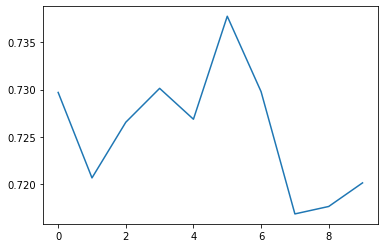

In [13]:
plt.plot(glob_loss)

In [14]:
model(input_ids[100:120].to(device), attention_masks[100:120].to(device))

tensor([[0.2239],
        [0.6940],
        [0.5437],
        [0.6028],
        [0.5003],
        [0.3854],
        [0.6037],
        [0.5559],
        [0.3122],
        [0.4669],
        [0.5585],
        [0.4863],
        [0.5556],
        [0.6356],
        [0.5411],
        [0.4301],
        [0.5550],
        [0.6666],
        [0.3831],
        [0.5147]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [20]:
labels[100:120]

tensor([1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1])

In [15]:
texts = df.iloc[:, 2].to_list()[7000:8000]
ids, att = get_ids(texts)
labels = torch.from_numpy(df.iloc[:, 0].to_numpy()[7000:8000])
dataset = TensorDataset(ids, att, labels)  # create your datset
dataloader_test = DataLoader(dataset, batch_size=100)

In [16]:
from collections import Counter
print(Counter(labels.numpy()))

723/1000

Counter({1: 723, 0: 277})


0.723

In [17]:
losses = []
correct = 0
for ids, att, y in dataloader_test:
    out = model(ids.to(device), att.to(device))
    correct += torch.sum(torch.round(out).squeeze() == y.squeeze().to(device))
    # print(out.shape)x
    loss = loss_fn(out.squeeze(), y.to(torch.float32).squeeze().to(device))
    losses.append(np.mean(loss.item()))
print(np.mean(losses))
print((correct / 1000).item())

0.7253999829292297
0.4820000231266022


In [18]:
model(ids[1:10].to(device), att[1:10].to(device))

tensor([[0.5295],
        [0.5428],
        [0.7278],
        [0.6379],
        [0.4998],
        [0.4058],
        [0.3623],
        [0.4754],
        [0.4822]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [19]:
y[1:10]

tensor([1, 1, 0, 1, 1, 1, 1, 1, 0])